In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import seaborn as sns
sns.set()
import pandas as pd
from scipy import signal
from scipy.fftpack import fft
import numba

In [39]:
def read_coverage(filename):
    coverage = []
    gene_ids = []
    with open(filename, 'r') as f:
        for line in f:
            c = line.strip().split('\t')
            gene_id = c[0]
            values = np.array(c[1:]).astype(np.float64)
            gene_ids.append(gene_id)
            coverage.append(values)
    return gene_ids, coverage

def call_peak(x, width=11):
    width = min(width, len(x))
    filter = np.full(width, 1.0/width)
    bg = signal.convolve(x, filter, mode='same')
    bg[np.isclose(bg, 0)] = 1
    snr = x/bg
    return (snr > 1.0).astype(np.int32)

def plot_coverage(gene_ids, cov, indices=30, need_call_peak=False):
    df = []
    if type(indices) is int:
        indices = range(indices)
    for i in indices:
        x = cov[i]
        if need_call_peak:
            x = call_peak(x)
        df_g = pd.DataFrame({'coverage': x})
        df_g['gene_id'] = gene_ids[i]
        df_g['position'] = np.arange(len(x))
        #df_g['position'] = np.linspace(0, 1, len(cov[dataset][i]), endpoint=True)
        df.append(df_g)
    df = pd.concat(df, axis=0)
    g = sns.FacetGrid(data=df, row="gene_id", 
                      row_order=df['gene_id'].unique(), 
                      size=0.8, aspect=16, sharey=False)
    g = g.map(plt.plot, 'position', 'coverage', drawstyle='steps', linewidth=1.0)

def fft_matrix(X, max_freq = 50):
    m = np.zeros((len(X), max_freq + 1))
    for i, x in enumerate(X):
        yf = fft(x)
        N = len(x)
        N_max = min(max_freq + 1, N//2)
        m[i, 0:N_max] = 2.0/N * np.abs(yf[0:N_max])
    m = np.clip(m, 0, 3)
    return m

@numba.jit('float64[:](int64[:], float64[:], float64[:, :], int64)')
def fill_period_matrix(t, yf, m, i):
    max_period = m.shape[1]
    for j in range(t.shape[0]):
        if t[j] <= max_period:
            m[i, t[j]] += yf[j]
    
def period_matrix(X, max_period = 50):
    m = np.zeros((len(X), max_period + 1))
    for i, x in enumerate(X):
        yf = fft(x)
        N = len(x)
        yf = 2.0/N * np.abs(yf[0:(N//2)])
        t = np.round(1.0*N/np.arange(1, N//2)).astype(np.int64)
        #m[i, 0:N_max] = 2.0/N * np.abs(yf[0:N_max])
        fill_period_matrix(t, yf, m, i)
    #m = np.clip(m, 0, 3)
    m /= np.sum(m, axis=1, keepdims=True)
    return m

def histogram_matrix(filename, output_file=None, bins=50, normalize='median'):
    records = []
    with open(filename, 'r') as f:
        for line in f:
            c = line.strip().split('\t')
            gene_id = c[0]
            values = np.array(c[1:]).astype(np.float64)
            scale = 0
            if normalize == 'median':
                scale = np.median(values)
            if (not np.isclose(scale, 0)) and (not np.isnan(scale)):
                values /= scale
                pass
            records.append((gene_id, values))
    gene_ids = np.array([r[0] for r in records])
    all_values = np.concatenate([r[1] for r in records])
    bins = np.linspace(0, np.percentile(all_values, 90), bins + 1, endpoint=True)
    bin_indices = np.arange(len(bins)).reshape((1, -1))
    print(bins)

    m = np.row_stack([np.sum(np.digitize(r[1], bins)[:, np.newaxis] == bin_indices, axis=0) for r in records])
    m = m.astype(np.float64)
    m_scale = np.sum(m, axis=1, keepdims=True)
    mask = ~np.isclose(m_scale, 0).flatten()
    m_scale[np.isclose(m_scale, 0)] = 1
    m /= m_scale
    m = m[mask]
    if output_file:
        df = pd.DataFrame(m, index=gene_ids)
        df.to_csv(output_file, sep='\t', header=False)
    return m

In [42]:
m_period = {}
m_period['exRNA_fraction'] = period_matrix(fraction['exRNA'], max_period=80)
m_period['tissue_fraction'] = period_matrix(fraction['tissue'], max_period=80)                                        

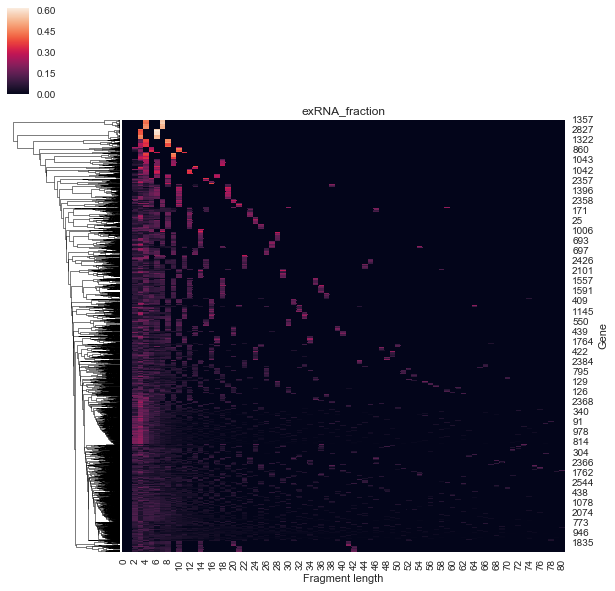

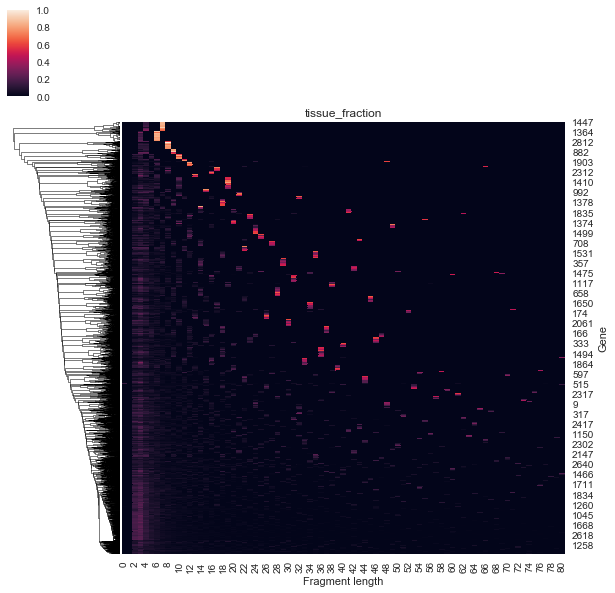

In [48]:
for dataset in m_period.keys():
    g = sns.clustermap(m_period[dataset][:5000], row_cluster=True, col_cluster=False)
    g.ax_heatmap.set_title(dataset)
    g.ax_heatmap.set_xlabel('Fragment length')
    g.ax_heatmap.set_ylabel('Gene')

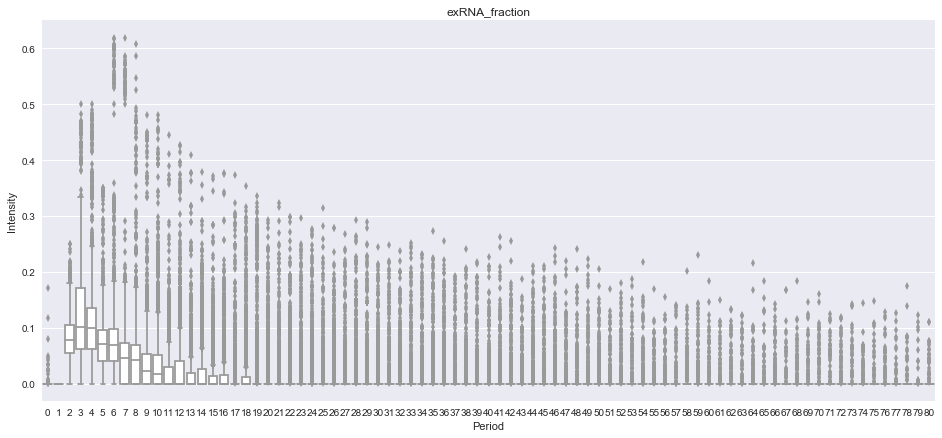

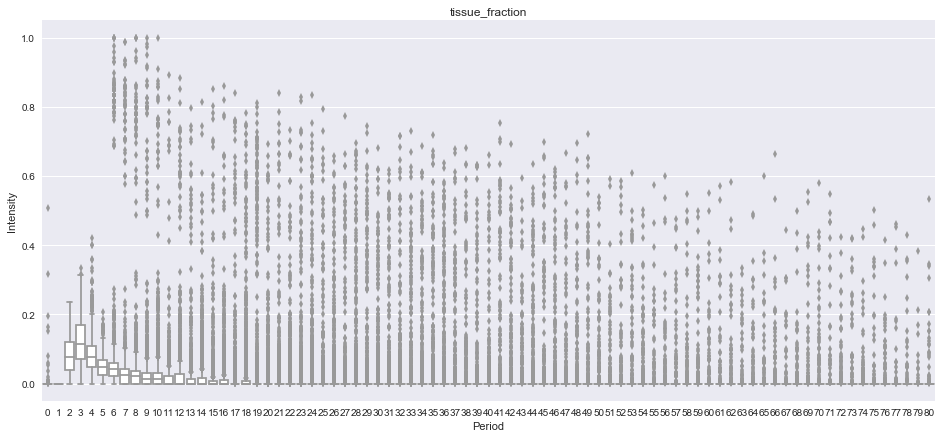

In [46]:
for dataset in m_period.keys():
    df = pd.DataFrame({'Period': np.tile(np.arange(m_period[dataset].shape[1]), m_period[dataset].shape[0]),
                       'Intensity': m_period[dataset].flatten()})
    fig, ax = plt.subplots(figsize=(16, 7))
    sns.boxplot('Period', 'Intensity', color='white', data=df, ax=ax)
    ax.set_title(dataset)

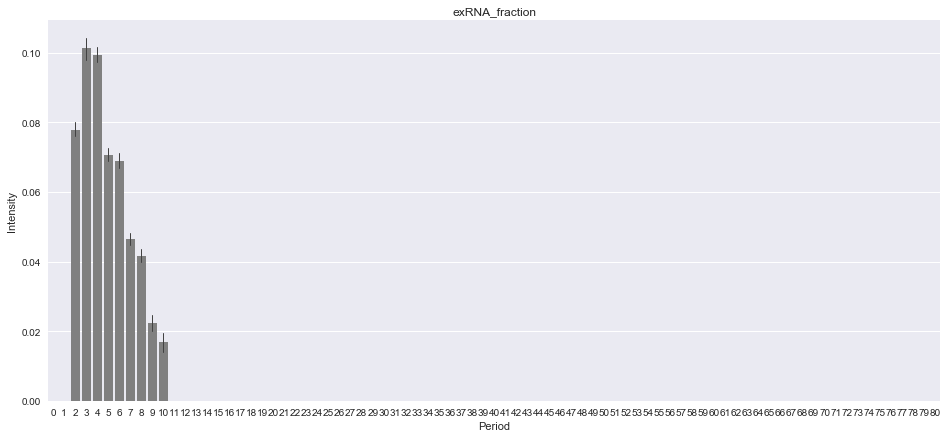

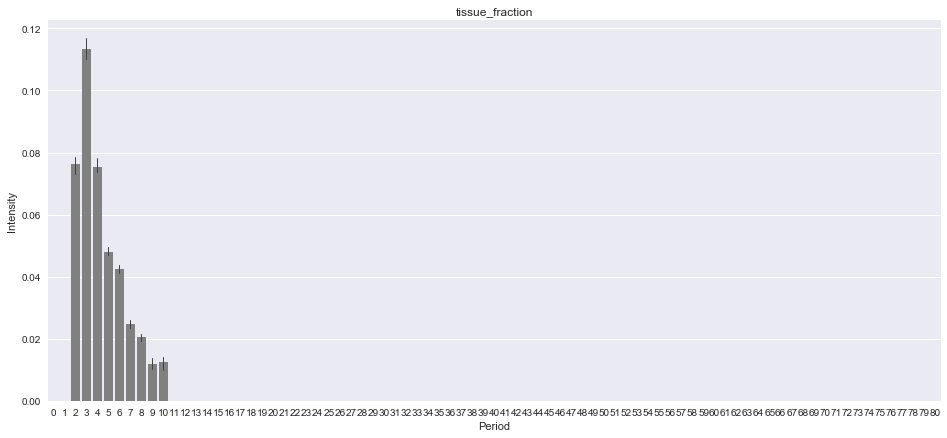

In [45]:
for dataset in m_period.keys():
    #agg_hist = np.mean(m_period[dataset], axis=0)
    #df = pd.DataFrame({'Density': agg_hist, 'Bin': np.arange(m_period[dataset].shape[1])})
    df = pd.DataFrame({'Period': np.tile(np.arange(m_period[dataset].shape[1]), m_period[dataset].shape[0]),
                       'Intensity': m_period[dataset].flatten()})
    fig, ax = plt.subplots(figsize=(16, 7))
    sns.barplot('Period', 'Intensity', color='gray', data=df, ax=ax, errwidth=1.0, estimator=np.median)
    ax.set_title(dataset)

In [4]:
fraction = {}
_, fraction['exRNA'] = read_coverage('/Share/home/caojingyi/exRNA/process/18.new_hcc_lulab/06.DE/0.name/no_mRNA/pheatmap/filt/candidate_all_mean.bedgraph.ratio_filt0.3')
_, fraction['tissue'] = read_coverage('/Share/home/caojingyi/exRNA/process/18.new_hcc_lulab/06.DE/0.name/no_mRNA/pheatmap/filt/candidate_all_mean.tissue.bedgraph.ratio_filt0.3')

In [5]:
cov = {}
gene_ids = {}
gene_ids['exRNA'], cov['exRNA'] = read_coverage('/Share/home/caojingyi/exRNA/process/18.new_hcc_lulab/06.DE/0.name/no_mRNA/pheatmap/bedgraph/candidate_all_mean.bedgraph')
gene_ids['tissue'], cov['tissue'] = read_coverage('/Share/home/caojingyi/exRNA/process/18.new_hcc_lulab/06.DE/0.name/no_mRNA/pheatmap/bedgraph/candidate_all_mean.tissue.bedgraph')

In [298]:
cov_gene = {}
for dataset in ('exRNA', 'tissue'):
    cov_gene[dataset] = np.array([np.percentile(a, 50) for a in cov[dataset]])

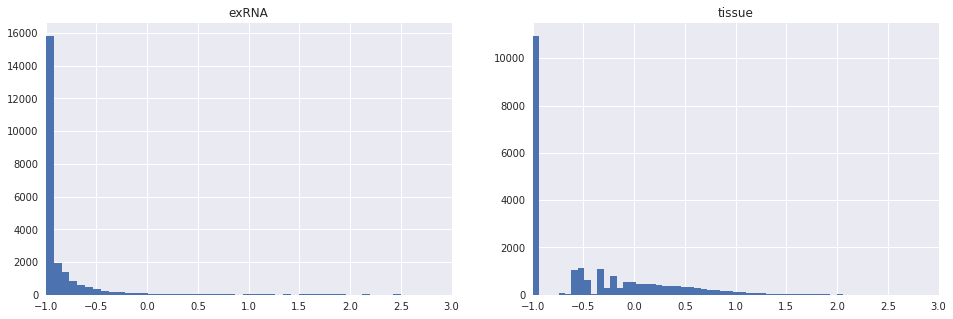

In [304]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
for i, dataset in enumerate(('exRNA', 'tissue')):
    axes[i].hist(np.log10(cov_gene[dataset] + 0.1), bins=100)
    axes[i].set_title(dataset)
    axes[i].set_xlim(-1, 3)

In [217]:
random_indices = np.random.choice(len(gene_ids['exRNA']), size=30, replace=False)

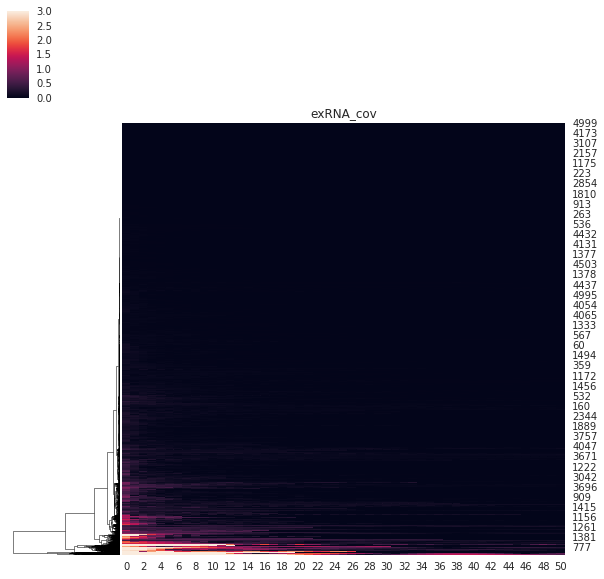

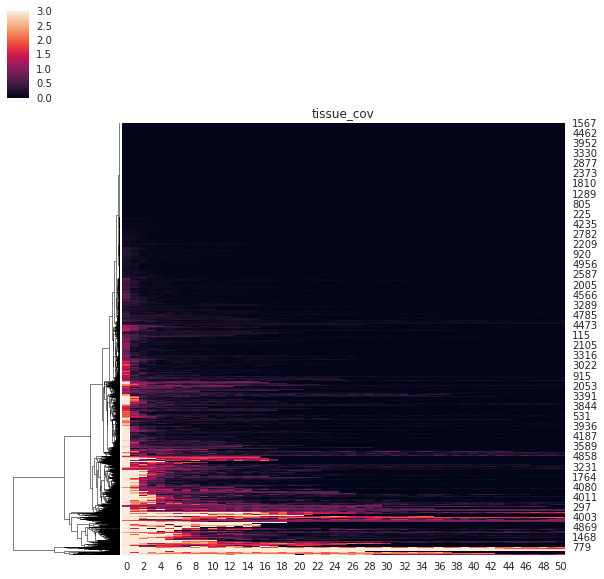

In [391]:
m_fft = {}
for dataset in ('exRNA', 'tissue'):
    m_fft[dataset + '_cov'] = fft_matrix(cov[dataset][:5000], max_freq=)
    m_fft[dataset + '_fraction'] = fft_matrix(fraction[dataset][:5000])

for dataset in ('exRNA', 'tissue'):
    g = sns.clustermap(m_fft[dataset + '_cov'], row_cluster=True, col_cluster=False)
    g.ax_heatmap.set_title(dataset + '_cov')

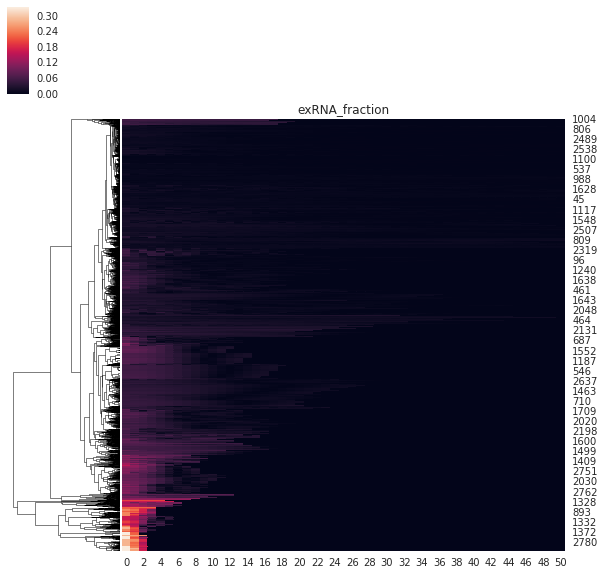

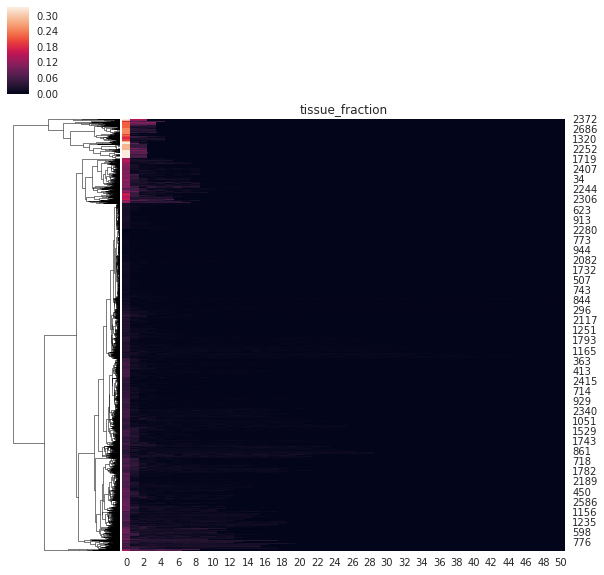

In [390]:
for dataset in ('exRNA', 'tissue'):
    g = sns.clustermap(m_fft[dataset + '_fraction'], row_cluster=True, col_cluster=False)
    g.ax_heatmap.set_title(dataset + '_fraction')

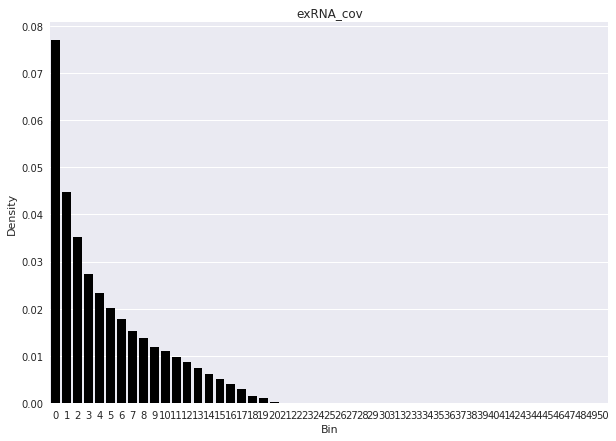

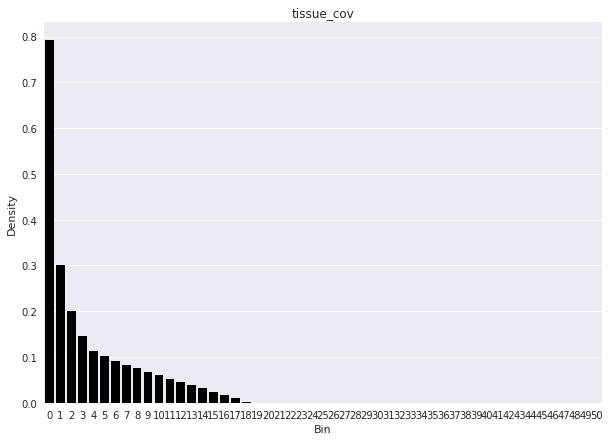

In [392]:
for dataset in ('exRNA_cov', 'tissue_cov'):
    agg_hist = np.median(m_fft[dataset], axis=0)
    df = pd.DataFrame({'Density': agg_hist, 'Bin': np.arange(m_fft[dataset].shape[1])})
    fig, ax = plt.subplots(figsize=(10, 7))
    sns.barplot('Bin', 'Density', color='black', data=df, ax=ax)
    ax.set_title(dataset)

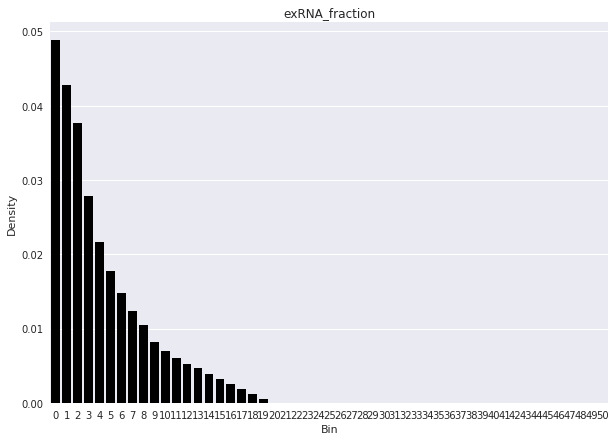

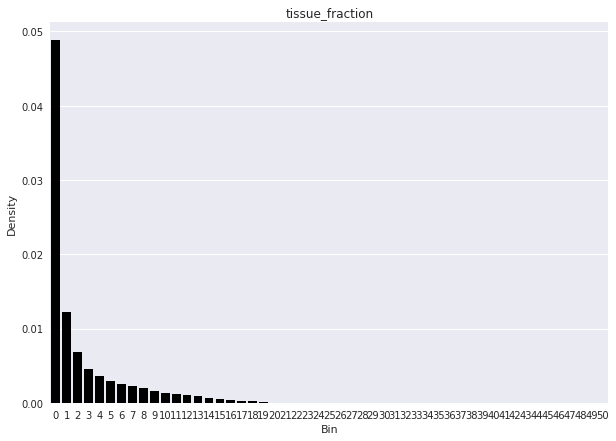

In [393]:
for dataset in ('exRNA_fraction', 'tissue_fraction'):
    agg_hist = np.median(m_fft[dataset], axis=0)
    df = pd.DataFrame({'Density': agg_hist, 'Bin': np.arange(m_fft[dataset].shape[1])})
    fig, ax = plt.subplots(figsize=(10, 7))
    sns.barplot('Bin', 'Density', color='black', data=df, ax=ax)
    ax.set_title(dataset)

In [204]:
RNA_types = np.unique([s.split('_')[0] for s in gene_ids['exRNA']])
print(RNA_types)

['YRNA' 'lncRNA' 'snRNA' 'snoRNA' 'srpRNA']


In [ ]:
m_exRNA = histogram_matrix('/Share/home/caojingyi/exRNA/process/18.new_hcc_lulab/06.DE/0.name/no_mRNA/pheatmap/filt/candidate_all_mean.bedgraph.ratio_filt0.3', output_file='histogram_matrix.txt')
m_tissue = histogram_matrix('/Share/home/caojingyi/exRNA/process/18.new_hcc_lulab/06.DE/0.name/no_mRNA/pheatmap/filt/candidate_all_mean.tissue.bedgraph.ratio_filt0.3')
m_exRNA = m_exRNA[:, 1:]
m_tissue = m_tissue[:, 1:]

In [175]:
m = {}
m['exRNA_median'] = histogram_matrix('/Share/home/caojingyi/exRNA/process/18.new_hcc_lulab/06.DE/0.name/no_mRNA/pheatmap/bedgraph/candidate_all_mean.bedgraph',
                                     normalize='median')
m['tissue_median'] = histogram_matrix('/Share/home/caojingyi/exRNA/process/18.new_hcc_lulab/06.DE/0.name/no_mRNA/pheatmap/bedgraph/candidate_all_mean.tissue.bedgraph',
                                     normalize='median')

[0.         0.04296488 0.08592976 0.12889464 0.17185952 0.2148244
 0.25778928 0.30075416 0.34371904 0.38668392 0.4296488  0.47261368
 0.51557856 0.55854344 0.60150832 0.6444732  0.68743808 0.73040296
 0.77336784 0.81633272 0.8592976  0.90226248 0.94522736 0.98819224
 1.03115712 1.074122   1.11708688 1.16005176 1.20301664 1.24598152
 1.2889464  1.33191128 1.37487616 1.41784104 1.46080592 1.5037708
 1.54673568 1.58970056 1.63266544 1.67563032 1.7185952  1.76156008
 1.80452496 1.84748984 1.89045472 1.9334196  1.97638448 2.01934936
 2.06231424 2.10527912 2.148244  ]
[0.         0.05959963 0.11919925 0.17879888 0.23839851 0.29799813
 0.35759776 0.41719739 0.47679701 0.53639664 0.59599626 0.65559589
 0.71519552 0.77479514 0.83439477 0.8939944  0.95359402 1.01319365
 1.07279328 1.1323929  1.19199253 1.25159216 1.31119178 1.37079141
 1.43039104 1.48999066 1.54959029 1.60918992 1.66878954 1.72838917
 1.78798879 1.84758842 1.90718805 1.96678767 2.0263873  2.08598693
 2.14558655 2.20518618 2.2647

In [ ]:
g = sns.clustermap(m_exRNA, row_cluster=True, col_cluster=False)
g.ax_heatmap.set_title('exRNA')
g = sns.clustermap(m_tissue, row_cluster=True, col_cluster=False)
g.ax_heatmap.set_title('Tissue')

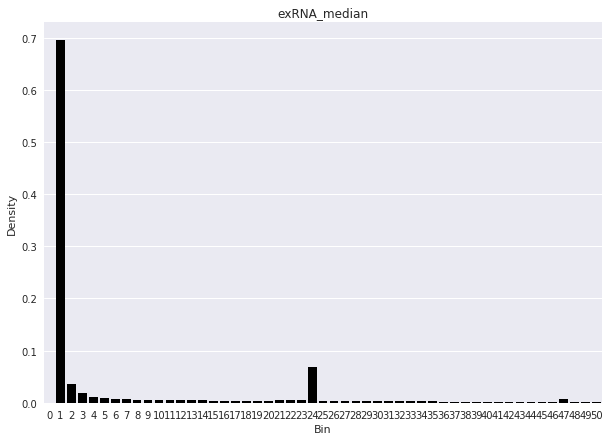

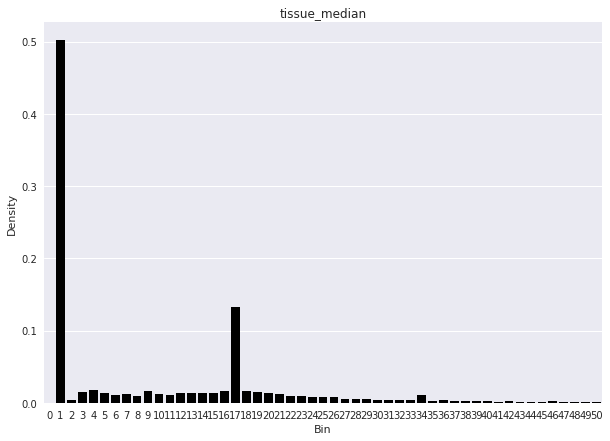

In [176]:
for dataset in m.keys():
    agg_hist = np.mean(m[dataset], axis=0)
    df = pd.DataFrame({'Density': agg_hist, 'Bin': np.arange(m[dataset].shape[1])})
    fig, ax = plt.subplots(figsize=(10, 7))
    sns.barplot('Bin', 'Density', color='black', data=df, ax=ax)
    ax.set_title(dataset)